In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.5 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import tensorflow_io as tfio
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10unique_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [ np.array(kpts_x), np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    #print(keypoints_with_scores)
    return keypoints_with_scores

In [ ]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  #print(keypoints_with_scores)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0])
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1])
  return keypoints_with_scores

In [ ]:
# Load the input image.
import random
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.int8)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (225,225), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

video_path = '/content/drive/MyDrive/EECE_5644_FINAL_PROJECT/data/test/ML EXCERCISE VIDEOS/SQUAT/ORIGINAL/VIDEO1.mp4'
image = frames_from_video_file(video_path, n_frames = 30)
image.shape
#image = tf.io.read_file(image_path)
#print(image)
#image = tf.image.decode_image(image)
#image = tf.image.decode_gif(image)

(30, 225, 225, 3)

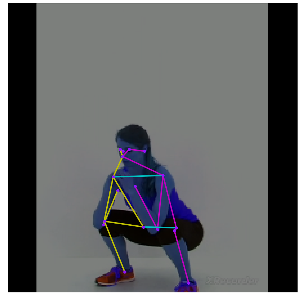

[[[[118.783554    88.73122      0.56734395]
   [113.20518     93.73891      0.7431888 ]
   [113.333694    86.672066     0.74642855]
   [114.67361    105.67692      0.8214787 ]
   [114.46455     89.02178      0.62876105]
   [133.55438    120.09582      0.83824337]
   [134.64291     81.33747      0.85868406]
   [175.63448    115.808556     0.53882986]
   [171.83586     73.78823      0.72232276]
   [141.92792     98.37487      0.45323905]
   [144.94632     84.89552      0.3703964 ]
   [174.221      130.44878      0.5786556 ]
   [173.59091    104.78484      0.48667496]
   [176.27338    128.85622      0.45965368]
   [169.18631     74.51622      0.65096873]
   [217.24185    140.05911      0.71420044]
   [208.65315     90.38402      0.8248029 ]]]]


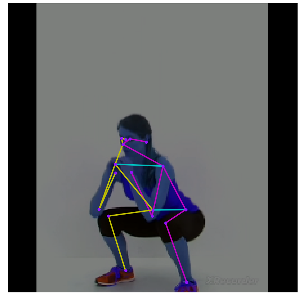

[[[[109.35271     88.87802      0.59896755]
   [105.04162     94.41346      0.7599318 ]
   [104.541565    87.78974      0.7983546 ]
   [107.425606   107.051895     0.7354025 ]
   [105.639       91.02207      0.7078397 ]
   [126.27934    120.05967      0.74229825]
   [124.81467     82.88315      0.79554147]
   [165.19179    111.54819      0.49201947]
   [159.86432     70.41347      0.58581793]
   [131.08197     95.46993      0.53942513]
   [131.53143     83.19027      0.4599387 ]
   [160.17383    137.6769       0.6583692 ]
   [160.37529    112.07612      0.67318255]
   [170.49713    122.10442      0.5953147 ]
   [165.13802     77.63726      0.6362231 ]
   [216.56606    138.44208      0.7331311 ]
   [207.57375     90.95326      0.8258732 ]]]]


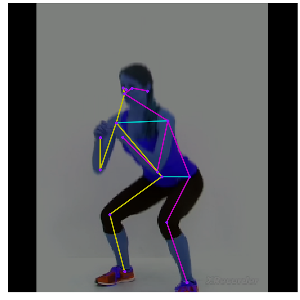

[[[[ 70.03485     90.24669      0.6235085 ]
   [ 65.58587     95.834465     0.5561251 ]
   [ 65.50566     89.03107      0.4420865 ]
   [ 67.72106    107.81202      0.6539863 ]
   [ 66.69194     91.46692      0.74676895]
   [ 91.0493     123.827385     0.79975235]
   [ 92.59057     83.77791      0.85390824]
   [130.71458    115.55428      0.82593966]
   [129.17572     71.17414      0.8307631 ]
   [103.87062     88.668724     0.6188421 ]
   [103.9147      71.24949      0.4720494 ]
   [134.5774     140.822        0.8651129 ]
   [134.42302    119.23408      0.6476393 ]
   [169.82446    122.87875      0.7766014 ]
   [163.85535     78.72552      0.69807726]
   [216.89093    138.73912      0.83755815]
   [208.23222     90.185684     0.8833433 ]]]]


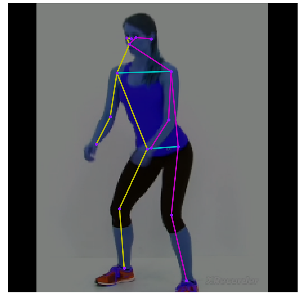

[[[[ 31.462479    93.998726     0.55304986]
   [ 26.258364    98.98369      0.65752906]
   [ 26.494722    91.959694     0.688333  ]
   [ 27.263794   110.76763      0.81288093]
   [ 27.1451      95.51202      0.5356863 ]
   [ 52.62924    126.391426     0.79783386]
   [ 53.81415     84.29759      0.9074239 ]
   [ 90.28693    124.471985     0.5611949 ]
   [ 87.90984     79.065544     0.71098375]
   [112.012375   110.80164      0.68681896]
   [109.29303     68.1751       0.8774288 ]
   [111.10237    131.93901      0.90831745]
   [112.85978    107.767265     0.8596669 ]
   [164.20535    126.59676      0.84318185]
   [159.27283     86.25903      0.88289094]
   [215.37285    138.44667      0.89484143]
   [205.45874     89.908775     0.8996799 ]]]]


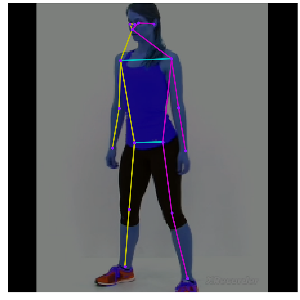

[[[[ 20.057486    96.15124      0.8057486 ]
   [ 14.917555   101.11439      0.8627725 ]
   [ 15.594209    94.38154      0.63944095]
   [ 15.660473   113.023125     0.767894  ]
   [ 16.114288    98.147446     0.6484621 ]
   [ 42.74906    126.73496      0.87371093]
   [ 44.156277    87.139496     0.9274538 ]
   [ 80.73488    132.15857      0.77307427]
   [ 81.45626     85.93756      0.90726894]
   [114.2727     137.55365      0.54896045]
   [112.09391     80.82928      0.8341801 ]
   [107.498314   119.95874      0.87827736]
   [107.971535    97.84952      0.8384296 ]
   [162.59785    126.93669      0.822403  ]
   [159.93518     93.73826      0.77659863]
   [213.67549    139.12079      0.7476599 ]
   [204.53645     90.405136     0.9107884 ]]]]


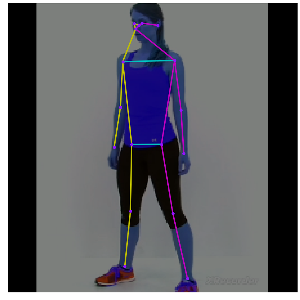

[[[[ 19.614187    98.78156      0.63025004]
   [ 15.060244   103.72612      0.724763  ]
   [ 15.583055    97.477905     0.7234924 ]
   [ 16.81529    115.9332       0.79781514]
   [ 16.68051    101.47003      0.6852317 ]
   [ 44.089375   129.13316      0.9369295 ]
   [ 45.043625    88.789795     0.8863834 ]
   [ 82.65867    134.11299      0.7816669 ]
   [ 80.5462      86.96994      0.8639768 ]
   [116.40378    136.29303      0.8402666 ]
   [111.68236     82.09558      0.85169506]
   [109.30299    118.89416      0.90494525]
   [109.38767     95.73557      0.8655919 ]
   [163.15799    127.76721      0.8312367 ]
   [161.40704     94.72841      0.8585859 ]
   [213.57394    139.07811      0.7557501 ]
   [204.33435     90.37502      0.91466415]]]]


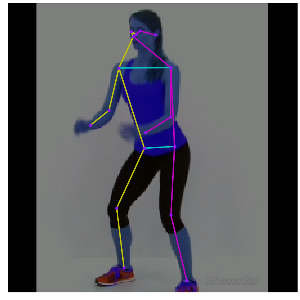

[[[[ 25.571135    97.03571      0.86060804]
   [ 21.163755   102.07221      0.829244  ]
   [ 21.583836    95.46823      0.81592184]
   [ 24.171741   113.932594     0.7795381 ]
   [ 23.947475    99.18264      0.6404563 ]
   [ 49.724625   126.23519      0.87507564]
   [ 49.94816     85.76787      0.8956971 ]
   [ 88.21162    126.03621      0.83740485]
   [ 82.95085     78.07258      0.8282465 ]
   [100.329735   106.59754      0.7531731 ]
   [ 94.480316    63.63321      0.7704891 ]
   [111.02425    129.09032      0.7556065 ]
   [112.353325   105.576645     0.88288754]
   [164.23994    126.25659      0.8246306 ]
   [158.96283     84.05806      0.8138125 ]
   [215.33116    138.55515      0.8994866 ]
   [205.2765      89.79698      0.9123557 ]]]]


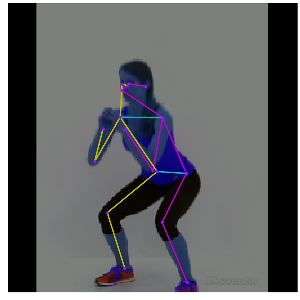

[[[[ 67.266594    88.164986     0.663519  ]
   [ 62.22156     93.50336      0.66805345]
   [ 62.334812    88.07289      0.72279817]
   [ 64.21303    106.41347      0.7771493 ]
   [ 63.758656    92.54102      0.63413286]
   [ 88.58045    119.82881      0.78929406]
   [ 88.21066     86.78228      0.7798356 ]
   [129.65666    112.16727      0.7336772 ]
   [122.76499     66.945305     0.87635475]
   [ 97.84265     90.72803      0.65164584]
   [ 97.17487     73.43267      0.7993426 ]
   [131.96558    138.23576      0.87441343]
   [130.52461    115.493546     0.77185774]
   [169.96298    119.45069      0.88543206]
   [162.53246     76.754944     0.8846713 ]
   [216.59851    138.7901       0.8628991 ]
   [205.8718      90.39749      0.8342433 ]]]]


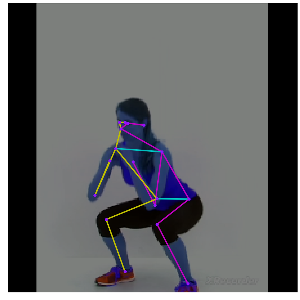

[[[[ 97.17565     87.362724     0.7552428 ]
   [ 92.84267     92.62301      0.68311715]
   [ 92.22985     86.220024     0.7629069 ]
   [ 94.43014    105.03563      0.6867671 ]
   [ 92.22019     90.56547      0.68805325]
   [115.12472    119.26719      0.8516582 ]
   [112.623985    83.35723      0.7510909 ]
   [156.58691    113.76398      0.6449553 ]
   [148.97173     67.15766      0.8392888 ]
   [122.9906      96.68968      0.67809564]
   [122.05945     78.63601      0.6150503 ]
   [151.9248     140.30731      0.8000076 ]
   [151.67862    115.43095      0.7898676 ]
   [171.52501    115.51137      0.5919769 ]
   [167.76292     75.8724       0.855448  ]
   [217.68451    139.34172      0.8548802 ]
   [208.40176     90.520226     0.8555332 ]]]]


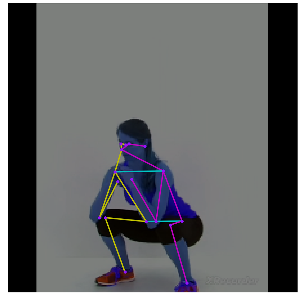

[[[[113.589554    87.94552      0.67314273]
   [109.021484    93.43994      0.7142724 ]
   [108.7651      87.39976      0.7250807 ]
   [110.85875    106.01328      0.8388295 ]
   [109.57134     90.97135      0.67436063]
   [130.07204    120.24516      0.8810687 ]
   [130.68935     82.76191      0.66601735]
   [169.41078    114.69431      0.59174734]
   [166.46506     70.624245     0.5864479 ]
   [136.51776     95.622        0.36682388]
   [138.33632     84.84958      0.3911603 ]
   [168.98141    134.93631      0.6890872 ]
   [169.37268    107.06587      0.5954218 ]
   [172.05171    125.75387      0.5486054 ]
   [166.35297     75.11513      0.59415895]
   [217.25124    138.65894      0.6715644 ]
   [208.41476     90.422066     0.8170641 ]]]]


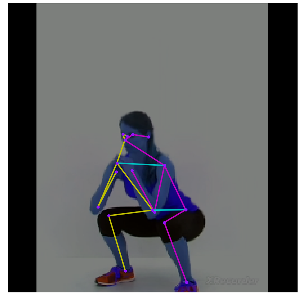

[[[[106.04131     90.4406       0.7443615 ]
   [101.73112     96.59171      0.7716829 ]
   [101.416626    88.914154     0.5804212 ]
   [103.612114   108.97079      0.7238303 ]
   [102.84049     92.02655      0.5480009 ]
   [125.75633    121.213936     0.844092  ]
   [123.938156    84.23421      0.8580138 ]
   [161.97787    113.4775       0.6779336 ]
   [157.94754     69.54675      0.77852887]
   [129.62303     95.830925     0.56120145]
   [130.724       83.861626     0.5082941 ]
   [160.22325    137.74965      0.6864728 ]
   [160.50996    111.944695     0.69925046]
   [170.06952    121.06277      0.63531816]
   [164.87318     77.87356      0.6876593 ]
   [216.55528    138.37444      0.7235357 ]
   [207.80333     90.84032      0.8326801 ]]]]


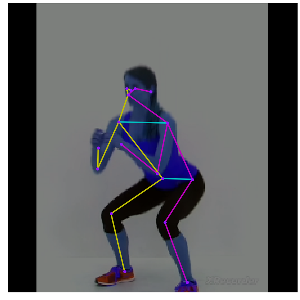

[[[[ 70.751526    92.95983      0.6020922 ]
   [ 65.88112     98.39         0.50796646]
   [ 66.01457     91.84117      0.57023025]
   [ 68.51154    110.51342      0.8324583 ]
   [ 67.39895     95.18301      0.7616824 ]
   [ 92.73495    123.58738      0.75286454]
   [ 91.90411     85.69909      0.90764874]
   [132.12872    115.67145      0.84002155]
   [128.29514     69.31772      0.8962726 ]
   [109.22047     87.59202      0.7204865 ]
   [112.1284      69.695656     0.5250564 ]
   [136.59155    143.00395      0.85207605]
   [135.85168    119.74443      0.7091473 ]
   [169.9385     121.56742      0.86373734]
   [163.23973     79.65733      0.7435639 ]
   [216.72038    138.777        0.8401947 ]
   [208.28743     90.227905     0.8861669 ]]]]


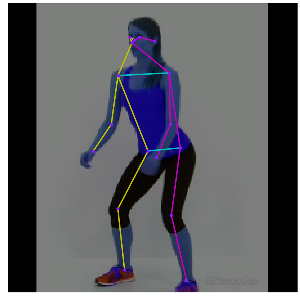

[[[[ 30.320354    96.04601      0.8020109 ]
   [ 26.075062   101.56281      0.88589483]
   [ 26.200949    94.25531      0.72362494]
   [ 28.884638   113.409065     0.7462194 ]
   [ 28.096478    97.93307      0.6201059 ]
   [ 53.80071    124.84378      0.8074693 ]
   [ 55.876648    85.04044      0.88150746]
   [ 93.83301    125.78337      0.84762925]
   [ 93.70317     79.89622      0.8862735 ]
   [119.8249     115.16523      0.73049766]
   [114.849266    65.661156     0.68215126]
   [112.11847    133.48447      0.89487815]
   [114.54874    108.44882      0.88060737]
   [164.6167     126.58573      0.868325  ]
   [159.45276     84.98241      0.862711  ]
   [214.91434    138.31664      0.90836006]
   [206.89471     90.18531      0.8999556 ]]]]


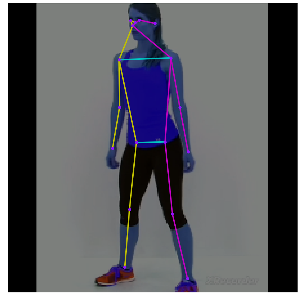

[[[[ 17.113585    96.48445      0.7316849 ]
   [ 12.700869   101.53824      0.83947664]
   [ 12.905865    94.73296      0.74845165]
   [ 15.3042755  113.87476      0.8051138 ]
   [ 14.570401    98.454865     0.5762804 ]
   [ 42.136322   126.25894      0.8653393 ]
   [ 43.55064     85.928696     0.92722076]
   [ 80.5364     133.14742      0.79146427]
   [ 80.58247     86.320595     0.90150845]
   [115.18937    139.62453      0.8183022 ]
   [112.535324    80.84198      0.832832  ]
   [107.45114    121.72047      0.84257185]
   [107.91464     99.37054      0.8731057 ]
   [163.34212    127.385185     0.8416973 ]
   [160.02513     94.00415      0.75739074]
   [213.7839     139.13011      0.72558045]
   [204.65697     90.38263      0.9102122 ]]]]


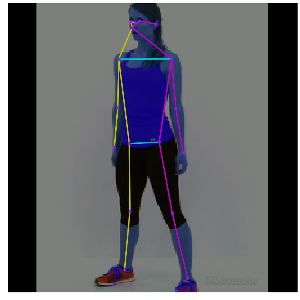

[[[[ 18.515652    96.130775     0.6151099 ]
   [ 13.376349   101.987404     0.7424749 ]
   [ 13.587998    95.11989      0.6908064 ]
   [ 15.856808   114.32761      0.8378942 ]
   [ 15.038712    98.72954      0.60890085]
   [ 42.92852    126.758606     0.8705251 ]
   [ 43.077744    85.65083      0.9197596 ]
   [ 81.24906    130.09152      0.65068173]
   [ 80.75838     84.92541      0.87250924]
   [115.84434    135.69572      0.7648646 ]
   [111.928955    82.24201      0.79872733]
   [107.64463    117.17584      0.8632333 ]
   [108.72935     93.893456     0.8440492 ]
   [162.8709     127.33388      0.8027952 ]
   [161.30824     94.36835      0.83413684]
   [213.32384    139.05562      0.7902632 ]
   [206.79652     90.185646     0.85473275]]]]


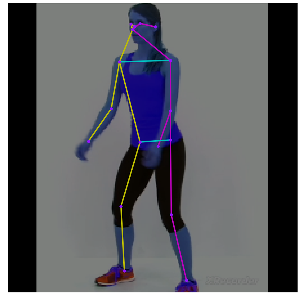

[[[[ 19.94447     96.448586     0.8494228 ]
   [ 15.337186   102.17803      0.7955721 ]
   [ 15.654429    95.0525       0.77773744]
   [ 17.983057   114.10455      0.8100401 ]
   [ 17.709843    97.86052      0.54018486]
   [ 43.99901    125.88724      0.9013702 ]
   [ 45.196724    86.24635      0.91797256]
   [ 83.29666    126.042984     0.7984361 ]
   [ 81.58225     79.84079      0.7941784 ]
   [110.89085    116.29668      0.81004053]
   [106.930145    62.12314      0.84597784]
   [105.94945    125.89127      0.85692024]
   [107.53065    102.24218      0.8397701 ]
   [164.09195    126.5413       0.8522144 ]
   [157.6096      87.41251      0.8378061 ]
   [215.07495    138.34436      0.8907806 ]
   [207.63005     90.05771      0.89797807]]]]


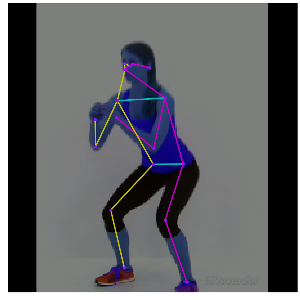

[[[[ 50.992428    90.59066      0.55037427]
   [ 46.666023    96.50494      0.7701496 ]
   [ 46.401936    89.977425     0.48029912]
   [ 49.710667   109.82503      0.8527222 ]
   [ 48.44577     94.18783      0.6787272 ]
   [ 73.3058     121.56305      0.88582706]
   [ 75.41861     84.617714     0.8230371 ]
   [112.68014    112.85         0.8704685 ]
   [111.042915    67.68003      0.9249999 ]
   [ 88.724365    84.167336     0.519394  ]
   [ 90.02665     67.33861      0.654148  ]
   [124.61384    135.79071      0.8792991 ]
   [124.843445   112.53865      0.7665232 ]
   [168.0604     121.78384      0.7554809 ]
   [160.38359     79.43767      0.59681034]
   [216.48517    138.70377      0.86897767]
   [205.25157     89.974365     0.8995733 ]]]]


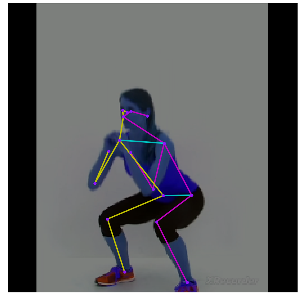

[[[[ 87.94565     89.311485     0.6019582 ]
   [ 83.58278     95.11914      0.7505733 ]
   [ 82.82235     88.69217      0.6116671 ]
   [ 87.19075    107.95531      0.68122995]
   [ 84.3081      92.14589      0.5745887 ]
   [108.491165   120.964325     0.74505514]
   [106.13152     86.28355      0.56279075]
   [144.20943    112.29151      0.7101796 ]
   [139.6613      67.11874      0.85583854]
   [115.51586     94.87169      0.6268444 ]
   [114.508385    77.78057      0.67676294]
   [148.89285    142.33205      0.74740547]
   [149.19005    120.26823      0.7439664 ]
   [169.54385    115.05234      0.641395  ]
   [167.43623     76.90226      0.8663392 ]
   [216.71985    138.75043      0.8178936 ]
   [208.44057     90.18691      0.8672027 ]]]]


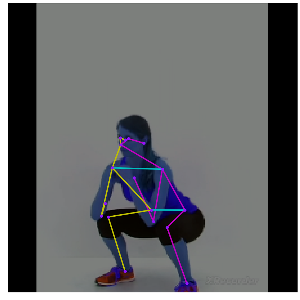

[[[[1.09633186e+02 8.71978378e+01 8.20768237e-01]
   [1.04964523e+02 9.33343582e+01 8.20573926e-01]
   [1.04296440e+02 8.67349014e+01 8.08792293e-01]
   [1.08456673e+02 1.05052513e+02 6.43177986e-01]
   [1.05951698e+02 9.07761612e+01 6.67327106e-01]
   [1.28660904e+02 1.19592407e+02 8.81051838e-01]
   [1.27637825e+02 8.06362457e+01 6.36451602e-01]
   [1.69343246e+02 1.12647346e+02 6.59534872e-01]
   [1.65170731e+02 7.20926590e+01 6.57859206e-01]
   [1.35365662e+02 9.76012955e+01 5.02773464e-01]
   [1.55303268e+02 7.50915833e+01 1.32695079e-01]
   [1.60471420e+02 1.37056274e+02 6.79756880e-01]
   [1.60369324e+02 1.11133934e+02 6.83581889e-01]
   [1.73844513e+02 1.23188042e+02 5.51179945e-01]
   [1.65855225e+02 7.74638824e+01 5.69785595e-01]
   [2.17575760e+02 1.38627121e+02 6.73412681e-01]
   [2.08135498e+02 9.06388168e+01 8.15497875e-01]]]]


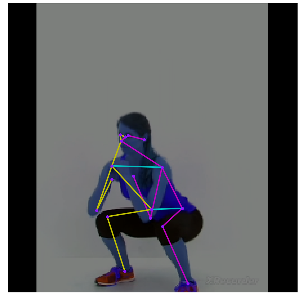

[[[[106.65171     87.505455     0.7467078 ]
   [102.50031     93.09995      0.6793119 ]
   [101.79922     86.6693       0.75458604]
   [105.689224   105.50249      0.8437482 ]
   [103.58888     90.70225      0.5429843 ]
   [127.191574   119.31666      0.8507556 ]
   [126.08797     80.338455     0.8032841 ]
   [166.70787    110.35616      0.6698708 ]
   [160.75433     68.48117      0.7734695 ]
   [133.96913     96.985214     0.4317121 ]
   [136.46162     80.34058      0.39151755]
   [159.07124    135.014        0.7341616 ]
   [159.95229    111.14554      0.70072037]
   [173.12715    119.75344      0.4355586 ]
   [165.6012      76.638695     0.6814104 ]
   [217.71169    139.54198      0.7666621 ]
   [207.9197      90.37062      0.78811187]]]]


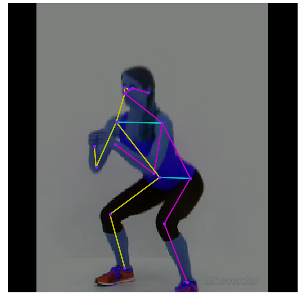

[[[[ 69.814445    90.41725      0.55707544]
   [ 65.62975     96.29957      0.5491189 ]
   [ 65.0186      89.872215     0.4564056 ]
   [ 69.2148     108.35011      0.75789726]
   [ 66.89015     93.79894      0.63203   ]
   [ 92.782616   119.61185      0.7927899 ]
   [ 92.0629      83.76393      0.86047864]
   [132.08173    112.99975      0.8495467 ]
   [127.0558      68.06114      0.8302077 ]
   [109.34937     83.109024     0.55749744]
   [110.701324    66.69285      0.5102301 ]
   [135.84303    141.2774       0.86817   ]
   [135.04251    117.4691       0.6981528 ]
   [171.01355    120.996284     0.8845252 ]
   [163.802       78.8131       0.69204867]
   [216.71115    138.81302      0.8559762 ]
   [205.53162     90.375854     0.84476227]]]]


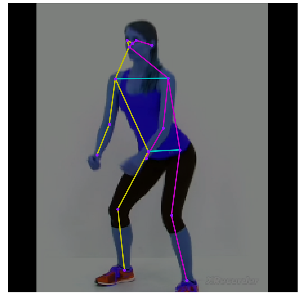

[[[[ 33.468582    93.75859      0.50600135]
   [ 28.480946    99.07905      0.5828507 ]
   [ 28.509495    92.25831      0.68294495]
   [ 32.12671    111.42965      0.7573235 ]
   [ 30.719202    96.089806     0.76898164]
   [ 57.938465   124.11468      0.93383354]
   [ 58.302185    83.01312      0.8368703 ]
   [ 96.86068    120.25015      0.8366231 ]
   [ 93.72242     78.295235     0.8793712 ]
   [120.13099    106.911415     0.8333973 ]
   [117.56097     68.762405     0.86259407]
   [113.64684    133.23814      0.911993  ]
   [114.83076    108.636116     0.85726017]
   [164.61377    126.684235     0.8320545 ]
   [159.62415     84.98916      0.83194435]
   [215.10635    138.48175      0.9071923 ]
   [207.11613     90.1286       0.8982568 ]]]]


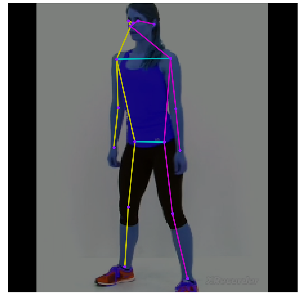

[[[[ 17.474194    94.928276     0.63717043]
   [ 13.181031   100.45818      0.81299555]
   [ 13.315872    93.17611      0.5350406 ]
   [ 15.730635   112.84233      0.6145226 ]
   [ 14.982716    96.87647      0.7097111 ]
   [ 42.539944   125.91608      0.9030916 ]
   [ 43.03013     84.07667      0.86444044]
   [ 81.59217    130.00708      0.67594576]
   [ 80.76134     85.109764     0.87744164]
   [113.93922    133.19832      0.8508854 ]
   [111.9828      81.844925     0.8680041 ]
   [107.59823    121.03539      0.87502396]
   [107.36125     98.20683      0.85405785]
   [163.17235    127.46477      0.83693147]
   [158.15602     93.082115     0.77821094]
   [213.64517    139.10883      0.74833363]
   [204.60663     90.37476      0.9077521 ]]]]


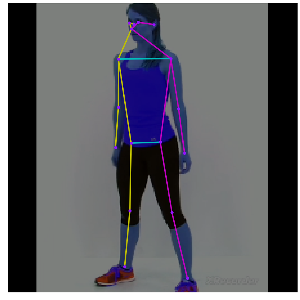

[[[[ 19.481358    95.63198      0.7410567 ]
   [ 14.46876    100.91353      0.7263995 ]
   [ 14.834403    93.87801      0.5206491 ]
   [ 16.142933   112.87555      0.7739932 ]
   [ 15.877045    97.51838      0.7084132 ]
   [ 42.67693    126.24659      0.8859202 ]
   [ 42.980675    85.39528      0.9130028 ]
   [ 81.58276    132.19188      0.7323832 ]
   [ 80.5753      85.3456       0.8520439 ]
   [116.31362    136.84854      0.81073123]
   [111.84184     83.14785      0.80006486]
   [107.67225    117.96524      0.87648517]
   [108.33812     95.296196     0.854666  ]
   [162.4454     127.06621      0.8004054 ]
   [161.06454     94.32784      0.8297793 ]
   [213.4312     139.0547       0.77709854]
   [204.3775      90.269905     0.9010213 ]]]]


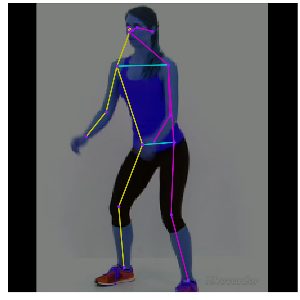

[[[[ 22.023655    94.14647      0.6244474 ]
   [ 18.34662     99.95233      0.72501004]
   [ 18.287619    92.973915     0.59110665]
   [ 21.546963   111.57272      0.800561  ]
   [ 20.482012    96.19112      0.8053034 ]
   [ 47.53598    124.047714     0.84502685]
   [ 48.519978    84.30311      0.9114183 ]
   [ 86.83675    125.66324      0.8043744 ]
   [ 83.93938     75.94435      0.8699942 ]
   [107.04776    113.23729      0.7639821 ]
   [103.27985     60.399815     0.63017577]
   [107.78016    128.62875      0.91171604]
   [109.53422    104.21049      0.8905898 ]
   [163.9066     126.43213      0.8645189 ]
   [157.81949     85.65097      0.86188257]
   [214.77625    139.62288      0.657196  ]
   [205.09189     89.71988      0.91927415]]]]


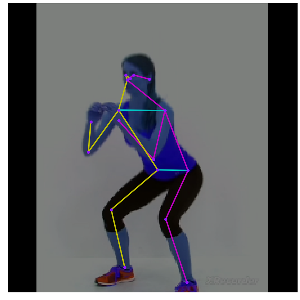

[[[[ 59.245712    92.22381      0.77565175]
   [ 55.38733     97.20362      0.79496795]
   [ 55.55567     90.96716      0.7301485 ]
   [ 58.619396   109.340836     0.8333747 ]
   [ 58.069893    94.46228      0.6851729 ]
   [ 83.047005   121.60971      0.8854641 ]
   [ 82.687874    85.59216      0.72744566]
   [121.03822    112.640175     0.6887958 ]
   [115.27638     62.029854     0.9013398 ]
   [ 90.8518      85.57729      0.41823947]
   [ 91.75163     63.979744     0.75394595]
   [129.63963    139.53218      0.8929912 ]
   [129.20166    116.02819      0.7227661 ]
   [167.37617    122.25557      0.83215153]
   [160.09438     79.79324      0.8511694 ]
   [216.57977    138.63968      0.87365466]
   [205.08424     90.34499      0.8944301 ]]]]


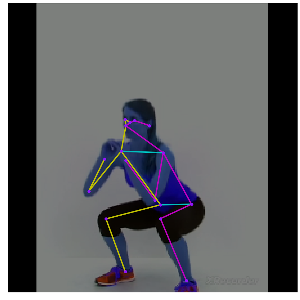

[[[[ 94.83555     91.20505      0.7944048 ]
   [ 90.79096     97.78439      0.7530154 ]
   [ 89.88547     90.54683      0.71795845]
   [ 94.785965   109.55358      0.72772187]
   [ 92.19195     94.31654      0.63011986]
   [115.854294   120.26497      0.762422  ]
   [114.69877     87.58838      0.79107785]
   [152.82718    113.82898      0.6639682 ]
   [145.80533     62.381577     0.84602726]
   [121.92488     90.95653      0.53189963]
   [120.72642     74.569664     0.7366523 ]
   [155.92595    142.26949      0.7362234 ]
   [156.35834    118.217384     0.7453368 ]
   [167.13907    118.10894      0.60771406]
   [167.30336     75.75319      0.8393058 ]
   [215.42633    138.27983      0.821616  ]
   [208.28136     90.75844      0.8598153 ]]]]


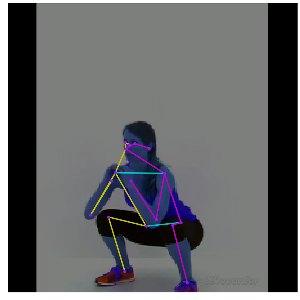

[[[[112.81743     91.10016      0.70174193]
   [108.67546     98.01078      0.6457377 ]
   [107.702774    90.542336     0.56130576]
   [112.44399    109.22513      0.5751847 ]
   [109.76728     94.076164     0.630321  ]
   [131.94637    121.28366      0.74328035]
   [131.42621     83.0551       0.7115225 ]
   [167.89732    114.809074     0.61248684]
   [164.21732     63.882465     0.737386  ]
   [137.88402     95.201454     0.46619686]
   [137.86552     79.942665     0.62132776]
   [170.1599     134.10033      0.72115314]
   [172.98097    106.998886     0.57080966]
   [172.07486    127.45981      0.50272965]
   [165.83427     77.60071      0.72847843]
   [216.8597     138.97485      0.6208307 ]
   [208.15045     90.39763      0.783334  ]]]]


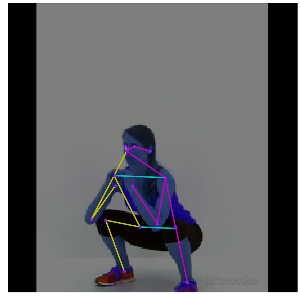

[[[[114.72769     91.904144     0.8409594 ]
   [111.01153     97.64222      0.75600076]
   [110.57957     90.52514      0.7961156 ]
   [114.65762    110.06973      0.8244749 ]
   [112.28786     92.52677      0.57521135]
   [135.24425    121.96781      0.8411428 ]
   [133.66391     82.049324     0.6978433 ]
   [171.20116    115.61548      0.50437146]
   [167.83383     64.26402      0.6789261 ]
   [141.53288     96.195335     0.5537067 ]
   [141.51044     83.04351      0.56629205]
   [174.79488    129.8385       0.64075494]
   [173.63403    102.20321      0.60813564]
   [173.52144    130.00417      0.5663829 ]
   [168.36241     75.53068      0.4894153 ]
   [216.96178    139.15094      0.6224645 ]
   [208.09988     89.99776      0.78922844]]]]


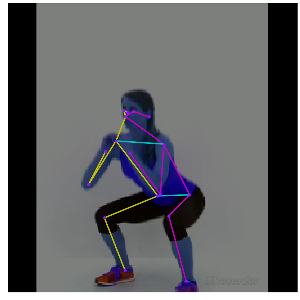

[[[[ 87.749435    91.01083      0.7187144 ]
   [ 83.70012     96.976845     0.81631756]
   [ 82.883316    89.71254      0.7029875 ]
   [ 87.89162    109.19425      0.8037361 ]
   [ 84.58073     92.307755     0.6774868 ]
   [109.1182     120.66043      0.68005764]
   [106.70933     83.5406       0.80921817]
   [148.31906    118.167076     0.61921316]
   [140.55086     62.199978     0.8758523 ]
   [116.400444    94.3044       0.61376864]
   [114.76089     75.54077      0.6988861 ]
   [148.63135    140.8432       0.83733475]
   [149.43965    116.044014     0.7238934 ]
   [165.02565    124.6056       0.6377019 ]
   [166.50256     74.48978      0.7558734 ]
   [215.63731    138.07927      0.8281044 ]
   [207.25499     90.493164     0.8527695 ]]]]



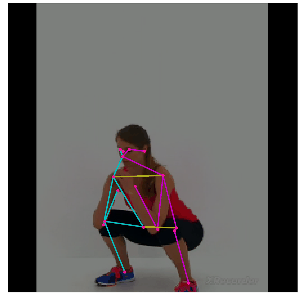

In [ ]:
from google.colab.patches import cv2_imshow
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
#bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(movenet, image[frame_idx, :, :, :], crop_region,crop_size=[input_size, input_size])
  #cv2_imshow(image[frame_idx, :, :, :].astype(np.int32))
  #print("random index is " + str(image[frame_idx, 200, 200, 1]))
  cv2_imshow(draw_prediction_on_image(image[frame_idx, :, :, :].astype(np.int32),keypoints_with_scores, crop_region=None,
     close_figure=True, output_image_height=300))
  output_images.append(draw_prediction_on_image(image[frame_idx, :, :, :].astype(np.int32),keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(keypoints_with_scores, image_height, image_width)
  print(keypoints_with_scores)

  #bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=10)
